## Part 1: Analyze the network

> Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.

In [76]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

The directed network is downloaded from a .graphml file.

In [63]:
G = nx.read_graphml("new_network/new_rock_artists.graphml")

### A. Qualitative Analysis

In a first analysis we will look at some qualitative measures.

**Highest in**

Artists with the highest in-degree are those most frequently mentioned across other artists’ Wikipedia pages. The three with the highest in-degree are The Beatles, The Rolling Stones, and Led Zeppelin. Examining ten of the artists who reference them shows that these connections often represent either direct influence or contemporaneity. Therefore, we can conclude that artists with the highest in-degree correspond to highly influential figures within the rock music world.

In [64]:
#Highest in
in_degrees = dict(G.in_degree())
sorted_nodes_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)
highest_in=sorted_nodes_in[:3]
print(highest_in)

[('the beatles', 171), ('the rolling stones', 122), ('led zeppelin', 119)]


In [65]:
#Neighbours pointing to
beatles_neigh=list(G.predecessors('the beatles'))
print(beatles_neigh[:10])

trs_neigh=list(G.predecessors('the rolling stones'))
print(trs_neigh[:10])

ledz_neigh=list(G.predecessors('led zeppelin'))
print(ledz_neigh[:10])

['breaking benjamin', 'stone temple pilots', 'linkin park', '10cc', 'the hollies', "herman's hermits", 'the moody blues', 'frank zappa', 'queen (band)', 'roxy music']
['korn', 'stone temple pilots', 'puddle of mudd', 'the yardbirds', 'the hollies', 'the beatles', 'the moody blues', 'roxy music', 'jethro tull (band)', 'ramones']
['korn', 'stone temple pilots', 'linkin park', 'puddle of mudd', 'the yardbirds', 'the moody blues', 'frank zappa', 'queen (band)', 'roxy music', 'the police']


**Highest out**

Artists with the highest out-degree are those who mention many other artists on their Wikipedia pages. The three with the highest out-degree are Alice in Chains, Deep Purple, and Black Sabbath. Reviewing their Wikipedia pages reveals extensive “influence” and “legacy” sections that reference numerous other musicians. As a result, their out-degree is high, and their neighboring nodes mainly represent artists they influenced or were influenced by.

In [66]:
#Highest out 
out_degrees = dict(G.out_degree())
sorted_nodes_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
highest_out=sorted_nodes_out[:3]
print(highest_out)

[('alice in chains', 77), ('deep purple', 76), ('black sabbath', 64)]


In [67]:
#Neighbours they point to
alice_neigh=list(G.successors('alice in chains'))
print(alice_neigh[:10])

dp_neigh=list(G.successors('deep purple'))
print(dp_neigh[:10])

bs_neigh=list(G.successors('black sabbath'))
print(bs_neigh[:10])

['nirvana (band)', 'pearl jam', 'soundgarden', "guns n' roses", 'david bowie', 'van halen', 'iggy pop', 'poison (american band)', 'extreme (band)', 'anthrax (american band)']
['rainbow (rock band)', 'whitesnake', 'joe satriani', 'led zeppelin', 'black sabbath', 'faces (band)', 'rod stewart', 'cream (band)', 'the moody blues', 'frank zappa']
['ozzy osbourne', 'dio (band)', 'rainbow (rock band)', 'deep purple', 'led zeppelin', 'jethro tull (band)', 'judas priest', 'yes (band)', 'eagles (band)', 'emerson, lake & palmer']


**Differences between reasons for out- and in-links**

In a Wikipedia-based rock artist network, out-links from an artist reflect who they mention on their page—typically influences, collaborators, or genre peers—while in-links to an artist reflect who mentions them, capturing their influence, popularity, or iconic status. As a result, out-degree measures how many artists a page references, whereas in-degree measures how widely an artist is recognized across pages. Legendary or highly influential artists tend to have high in-degree but modest out-degree, while lesser-known or contemporary artists may have the opposite.

**Heatmap**

In [68]:
in_d = [d for _, d in G.in_degree()]
out_d = [d for _, d in G.out_degree()]

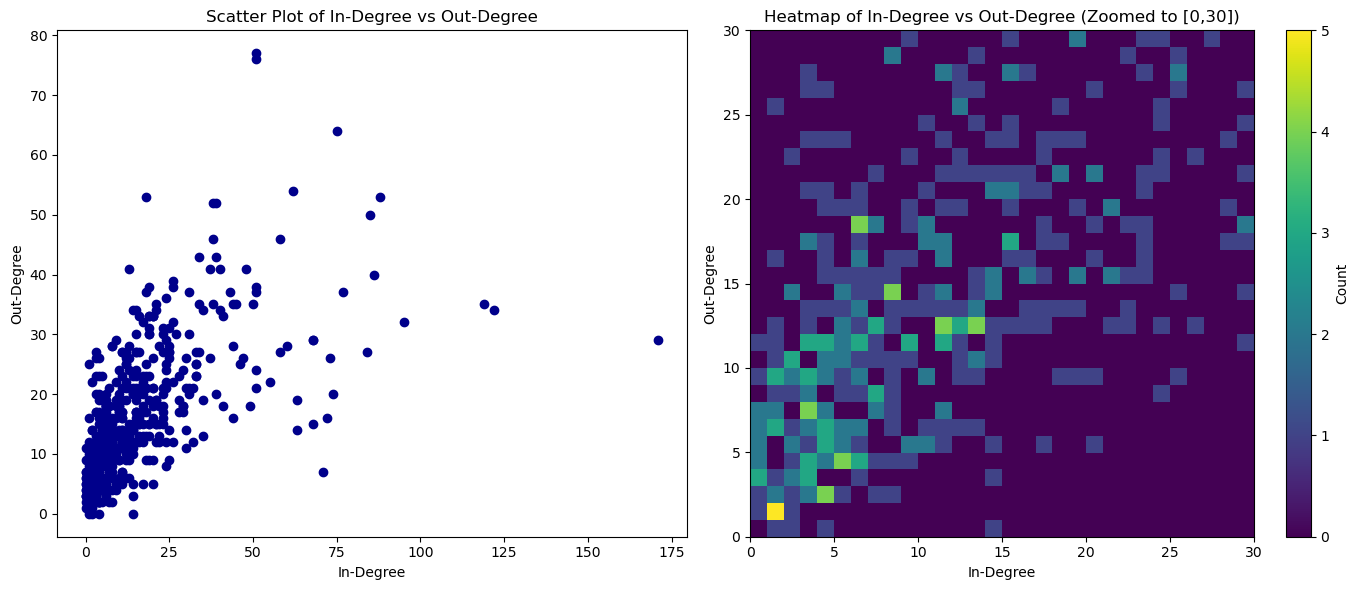

In [69]:
heatmap, xedges, yedges = np.histogram2d(in_d, out_d, bins=30, range=[[0, 30], [0, 30]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(in_d, out_d, marker='o', color='darkblue')
axes[0].set_title('Scatter Plot of In-Degree vs Out-Degree')
axes[0].set_xlabel('In-Degree')
axes[0].set_ylabel('Out-Degree')

im = axes[1].imshow(heatmap.T, extent=extent, origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title('Heatmap of In-Degree vs Out-Degree (Zoomed to [0,30])')
axes[1].set_xlabel('In-Degree')
axes[1].set_ylabel('Out-Degree')
axes[1].set_xticks(np.arange(0, 31, 5))
axes[1].set_yticks(np.arange(0, 31, 5))
fig.colorbar(im, ax=axes[1], label='Count')

plt.tight_layout()
plt.show()

Each point represents an artist, with x-axis = out-degree (how many other artists they mention) and y-axis = in-degree (how many pages mention them).

Patterns you might see:

Most artists cluster near the origin: low out-degree and low in-degree.

Highly influential or legendary artists (like Led Zeppelin or The Beatles) appear as outliers with very high in-degree but modest out-degree.

Some contemporary or niche artists may have higher out-degree than in-degree (they list many influences but are mentioned by few).

This plot allows a general sense of relationships, outliers, and the overall distribution, but in dense areas (many points with low degrees) points can overlap, making it hard to see patterns.

A heatmap represents the density of nodes at each in-/out-degree combination.

Advantages over the scatter plot:

Reveals dense clusters that are invisible in scatter plots due to overlapping points.

Makes it easier to see concentration of “average” artists with low in- and out-degrees.

Can zoom in on the dense region to inspect fine-grained patterns without being obscured by overplotting.

Essentially, the heatmap provides a clearer view of the distribution, especially in the crowded lower-degree area, whereas the scatter plot highlights outliers but can obscure the bulk of the nodes.

### B. Qualitative Analysis

**In degree distribution**

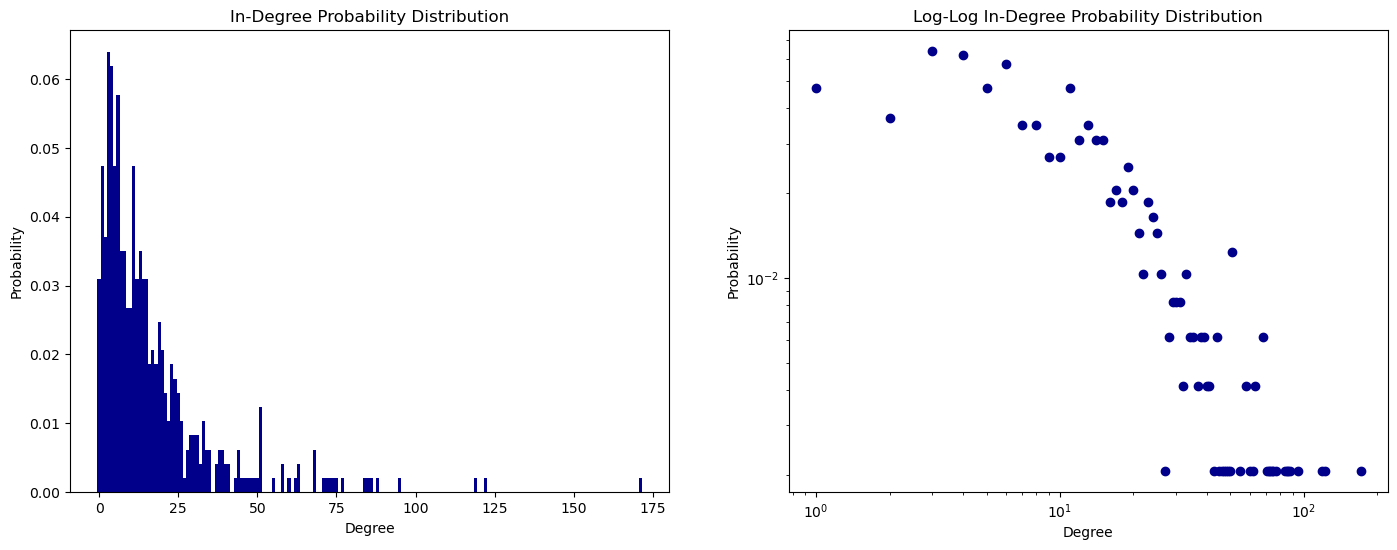

In [ ]:
#in_d = [d for _, d in G.in_degree()]
in_d_sort = sorted(in_d)

max_in=max(in_d_sort)
min_in=min(in_d_sort)
v_in=np.arange(min_in, max_in+2)

# counts
in_counts, in_bins = np.histogram(in_d_sort, bins=v_in)

# probabilities
in_probs = in_counts / in_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].bar(in_bins[:-1], in_probs, width=np.diff(in_bins), color='darkblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('In-Degree Probability Distribution')

axes[1].scatter(in_bins[:-1], in_probs, marker='o', color='darkblue')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log In-Degree Probability Distribution')
plt.show()

In [136]:
fit_in = powerlaw.Fit(in_d,discrete=True)
alpha_in = fit_in.alpha
print("In-degree exponent (alpha):", alpha_in)
print("xmin:", fit_in.xmin)

Calculating best minimal value for power law fit
In-degree exponent (alpha): 2.7123416618256444
xmin: 19.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


Since alpha between 2 and 3, é scale free

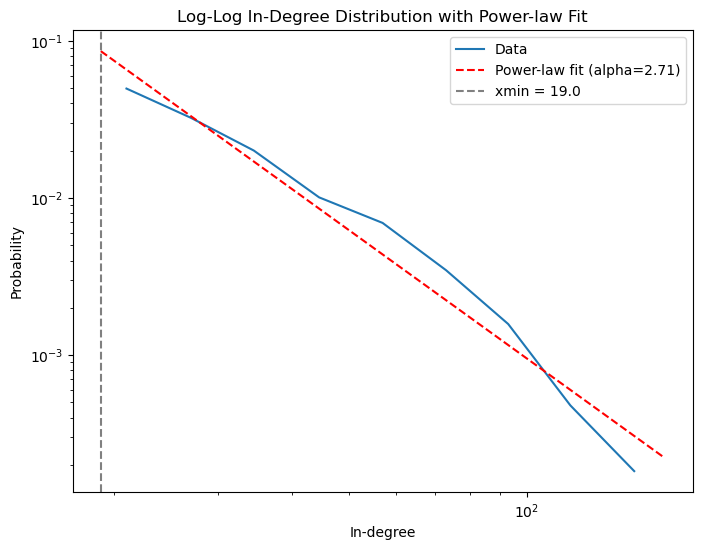

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))

# empirical pdf
fit_in.plot_pdf(label='Data')

# fitted power-law
fit_in.power_law.plot_pdf(color='red', linestyle='--', label=f'Power-law fit (alpha={alpha_in:.2f})')

plt.axvline(fit_in.xmin, color='gray', linestyle='--', label=f'xmin = {fit_in.xmin}')

ax.set_xlabel('In-degree')
ax.set_ylabel('Probability')
ax.set_title('Log-Log In-Degree Distribution with Power-law Fit')
ax.legend()
plt.show()

In [139]:
# Compare to log-normal
R_ln, p_ln = fit_in.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln, ", p =", p_ln)

# Compare to exponential
R_exp, p_exp = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp, ", p =", p_exp)


Power-law vs lognormal: R = -3.429503097832927 , p = 0.0985283815914586
Power-law vs exponential: R = -0.4404399184426442 , p = 0.9278100416306371


R (likelihood ratio):

R > 0 → data favors the first distribution (power_law)

R < 0 → data favors the second distribution (lognormal/exponential)

p-value: statistical significance of R.

p < 0.05 → result is significant

The in-degree distribution of the network shows a heavy-tailed behavior. The fitted power-law exponent is α = … with xmin = … . Likelihood ratio tests against lognormal and exponential distributions do not statistically favor any alternative, so a power-law tail is a plausible description.”

**Out degree distribution**

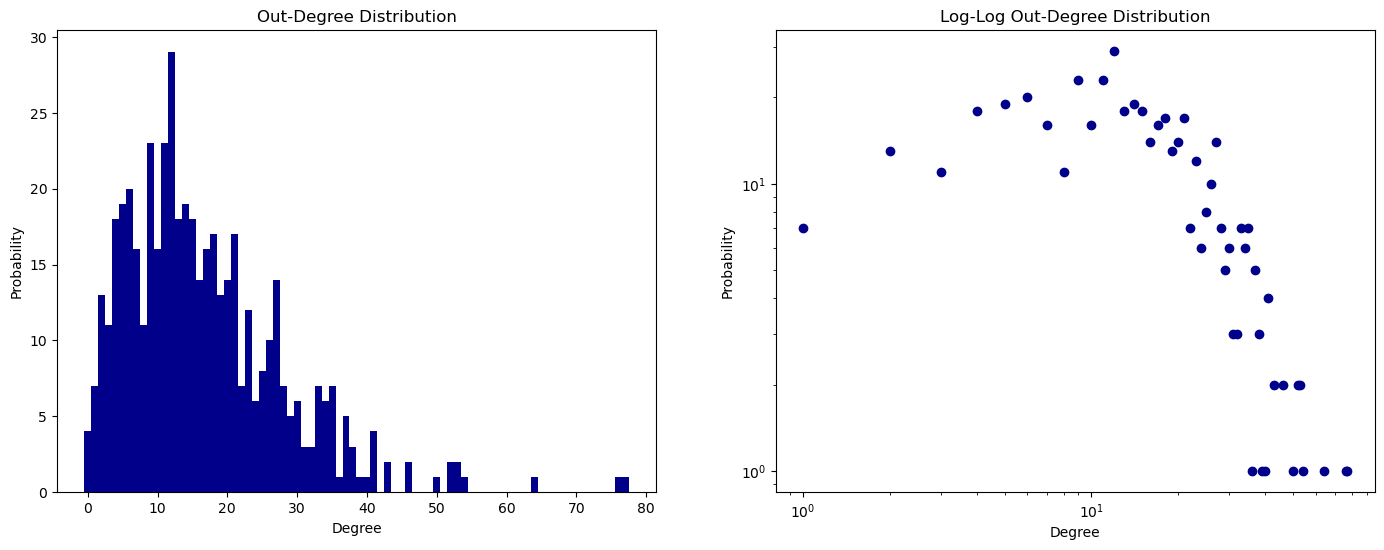

In [ ]:
out_d_sort = sorted(out_d)

max_out=max(out_d_sort)
min_out=min(out_d_sort)
v_out=np.arange(min_out, max_out+2)

# counts
out_counts, out_bins = np.histogram(out_d_sort, bins=v_out)
# probabilities
out_probs = out_counts / out_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(17, 6))

# in degree distribution
axes[0].bar(out_bins[:-1], out_counts, width=np.diff(out_bins), color='darkblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('Out-Degree Distribution')

# log-log in degree distribution
axes[1].scatter(out_bins[:-1], out_counts, marker='o', color = 'darkblue')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log Out-Degree Distribution')

plt.show()

In [144]:
fit_out = powerlaw.Fit(out_d,discrete=True)
alpha_out = fit_out.alpha
print("In-degree exponent (alpha):", alpha_out)
print("xmin:", fit_out.xmin)

Calculating best minimal value for power law fit
In-degree exponent (alpha): 5.830719630959893
xmin: 33.0


Values less than or equal to 0 in data. Throwing out 0 or negative values


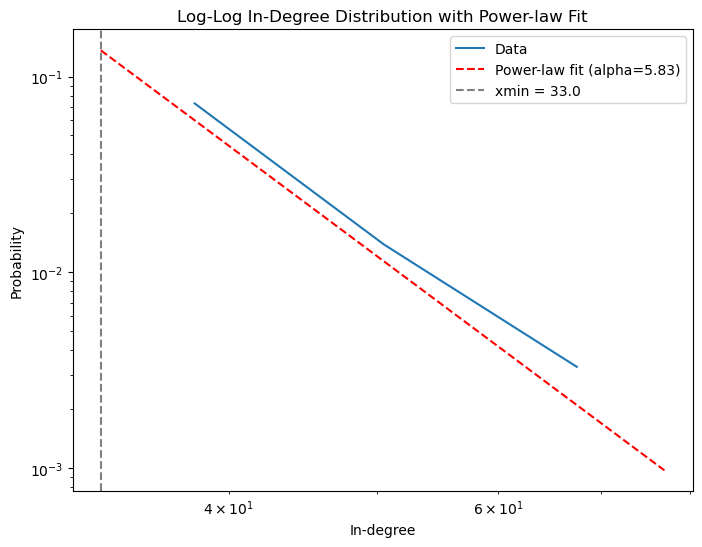

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot empirical PDF
fit_out.plot_pdf(label='Data')

# Plot fitted power-law
fit_out.power_law.plot_pdf(color='red', linestyle='--', label=f'Power-law fit (alpha={alpha_out:.2f})')

plt.axvline(fit_out.xmin, color='gray', linestyle='--', label=f'xmin = {fit_out.xmin}')

ax.set_xlabel('In-degree')
ax.set_ylabel('Probability')
ax.set_title('Log-Log In-Degree Distribution with Power-law Fit')
ax.legend()
plt.show()

In [148]:
# Compare to log-normal
R_ln, p_ln = fit_out.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln, ", p =", p_ln)

# Compare to exponential
R_exp, p_exp = fit_out.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp, ", p =", p_exp)

Power-law vs lognormal: R = 0.00042028205398869645 , p = 0.9731733439451171
Power-law vs exponential: R = 1.1946721301773109 , p = 0.2904683182203369


c:\Users\Maria\anaconda3\envs\sgi\Lib\site-packages\powerlaw.py:1570: RuntimeWarning: invalid value encountered in divide
  return likelihoods/norm


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power-law fit: alpha = 5.830719630959893 , xmin = 33.0
Log-normal fit: mu = -288.56564648964127 , sigma = 7.774826668133416
Exponential fit: lambda = 0.11804778851042169
Power-law vs lognormal: R = 0.00042028205398869645 , p = 0.9731733439451171
Power-law vs exponential: R = 1.1946721301773109 , p = 0.2904683182203369


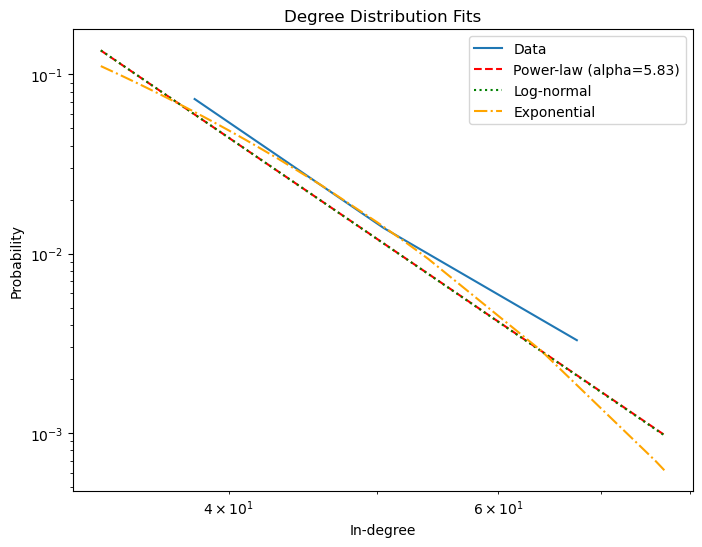

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# In-degree data
in_d = [d for _, d in G.out_degree()]

# Fit power-law (discrete data)
fit_in = powerlaw.Fit(in_d, discrete=True)

# Power-law parameters
alpha = fit_in.power_law.alpha
xmin = fit_in.power_law.xmin
print("Power-law fit: alpha =", alpha, ", xmin =", xmin)

# Log-normal parameters
mu = fit_in.lognormal.mu
sigma = fit_in.lognormal.sigma
print("Log-normal fit: mu =", mu, ", sigma =", sigma)

# Exponential parameters
lambda_exp = fit_in.exponential.parameter1
print("Exponential fit: lambda =", lambda_exp)

# Likelihood ratio tests
R_ln, p_ln = fit_in.distribution_compare('power_law', 'lognormal')
R_exp, p_exp = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs lognormal: R =", R_ln, ", p =", p_ln)
print("Power-law vs exponential: R =", R_exp, ", p =", p_exp)

# Plot PDF comparison
fig, ax = plt.subplots(figsize=(8,6))
fit_in.plot_pdf(label='Data')
fit_in.power_law.plot_pdf(color='red', linestyle='--', label=f'Power-law (alpha={alpha:.2f})')
fit_in.lognormal.plot_pdf(color='green', linestyle=':', label='Log-normal')
fit_in.exponential.plot_pdf(color='orange', linestyle='-.', label='Exponential')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('In-degree')
ax.set_ylabel('Probability')
ax.set_title('Degree Distribution Fits')
ax.legend()
plt.show()



Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Power-law fit: alpha = 2.7123416618256444 , xmin = 19.0
Log-normal fit: mu = 2.3359080462160744 , sigma = 0.9531969132015838
Exponential fit: lambda = 0.05182770022042621
Power-law vs lognormal: R = -3.429503097832927 , p = 0.0985283815914586
Power-law vs exponential: R = -0.4404399184426442 , p = 0.9278100416306371


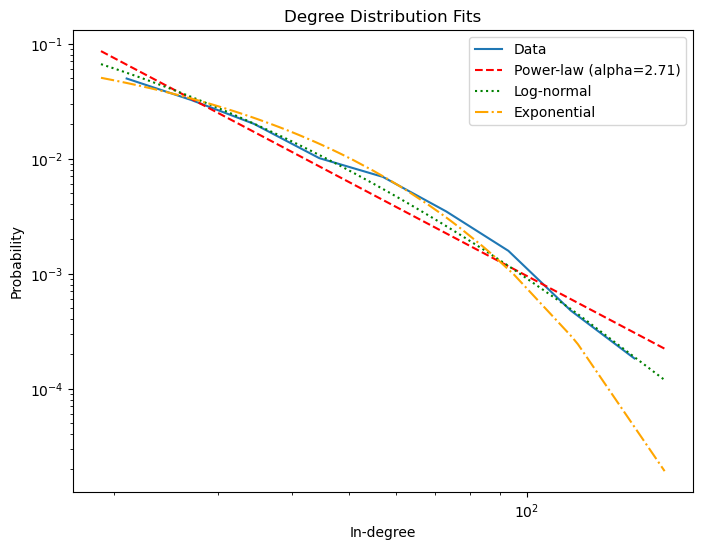

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

# In-degree data
in_d = [d for _, d in G.in_degree()]

# Fit power-law (discrete data)
fit_in = powerlaw.Fit(in_d, discrete=True)

# Power-law parameters
alpha = fit_in.power_law.alpha
xmin = fit_in.power_law.xmin
print("Power-law fit: alpha =", alpha, ", xmin =", xmin)

# Log-normal parameters
mu = fit_in.lognormal.mu
sigma = fit_in.lognormal.sigma
print("Log-normal fit: mu =", mu, ", sigma =", sigma)

# Exponential parameters
lambda_exp = fit_in.exponential.parameter1
print("Exponential fit: lambda =", lambda_exp)

# Likelihood ratio tests
R_ln, p_ln = fit_in.distribution_compare('power_law', 'lognormal')
R_exp, p_exp = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs lognormal: R =", R_ln, ", p =", p_ln)
print("Power-law vs exponential: R =", R_exp, ", p =", p_exp)

# Plot PDF comparison
fig, ax = plt.subplots(figsize=(8,6))
fit_in.plot_pdf(label='Data')
fit_in.power_law.plot_pdf(color='red', linestyle='--', label=f'Power-law (alpha={alpha:.2f})')
fit_in.lognormal.plot_pdf(color='green', linestyle=':', label='Log-normal')
fit_in.exponential.plot_pdf(color='orange', linestyle='-.', label='Exponential')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('In-degree')
ax.set_ylabel('Probability')
ax.set_title('Degree Distribution Fits')
ax.legend()
plt.show()

**Find degree exponent**

In [73]:
import powerlaw

total_d = [d for _, d in G.degree()]

fit_in = powerlaw.Fit(in_d,discrete=True)
alpha_in = fit_in.alpha

fit_out = powerlaw.Fit(out_d)
alpha_out = fit_out.alpha

fit_total = powerlaw.Fit(total_d)
alpha_total = fit_total.alpha

print("In-degree exponent (alpha):", alpha_in)
print("Out-degree exponent (alpha):", alpha_out)
print("Total-degree exponent (alpha):", alpha_total)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
In-degree exponent (alpha): 2.7123416618256444
Out-degree exponent (alpha): 6.215368029509343
Total-degree exponent (alpha): 4.5931874111267295


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Fitted in-degree power-law exponent: alpha = 2.71, xmin = 19.0


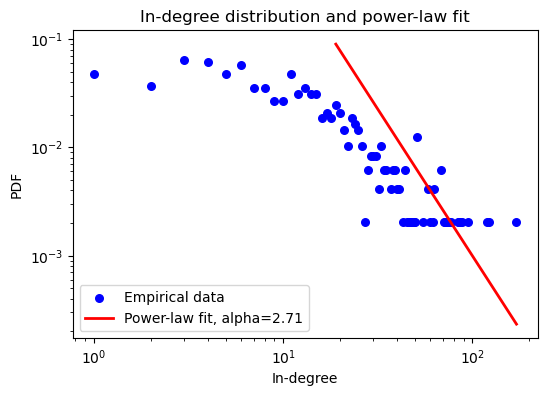

In [75]:
import networkx as nx
import powerlaw
import numpy as np
import matplotlib.pyplot as plt

# Example: your directed graph
# G = nx.read_edgelist("your_network.edgelist", create_using=nx.DiGraph())

# Get in-degree
in_degrees = [d for _, d in G.in_degree()]

# Fit power-law using powerlaw
fit_in = powerlaw.Fit(in_degrees, discrete=True)
alpha_in = fit_in.alpha
xmin_in = fit_in.xmin  # k_min for the fit

print(f"Fitted in-degree power-law exponent: alpha = {alpha_in:.2f}, xmin = {xmin_in}")

# Empirical PDF
values, counts = np.unique(in_degrees, return_counts=True)
pdf = counts / counts.sum()  # normalize

# Plotting
plt.figure(figsize=(6,4))

# Scatter plot of empirical PDF
plt.scatter(values, pdf, color='blue', label='Empirical data', s=30)

# Fitted power-law curve for k >= xmin
k = np.arange(xmin_in, max(values)+1)
pdf_fit = (alpha_in - 1) / xmin_in * (k / xmin_in) ** (-alpha_in)
plt.plot(k, pdf_fit, color='red', lw=2, label=f'Power-law fit, alpha={alpha_in:.2f}')

# Log-log scale
plt.xscale('log')
plt.yscale('log')
plt.xlabel("In-degree")
plt.ylabel("PDF")
plt.legend()
plt.title("In-degree distribution and power-law fit")
plt.show()


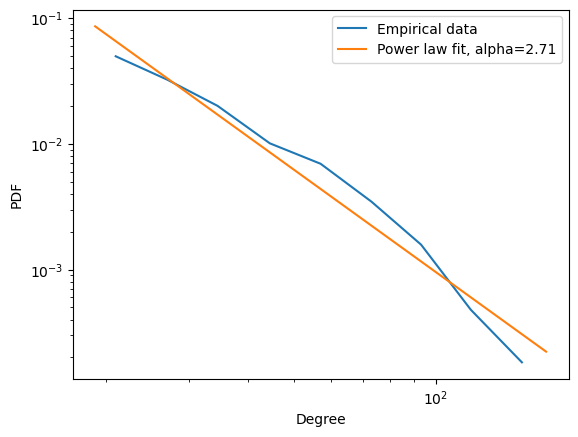

In [74]:
fit_in.plot_pdf(label='Empirical data')
fit_in.power_law.plot_pdf(label=f'Power law fit, alpha={alpha_in:.2f}')
plt.xlabel("Degree")
plt.ylabel("PDF")
plt.legend()
plt.show()

entre 2 e 3: scale free
maior que 3: hubs exist but less pronouced